In [33]:
# !pip install scikit-image
# !pip install matplotlib
# !pip install pyclesperanto_prototype
# !pip install zarr
# !pip install seaborn
# !pip install tensorflow
!

In [1]:
from pathlib import Path
import os
import glob
import napari
from napari.utils.notebook_display import nbscreenshot
from PIL import Image
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from cellpose import models, io
from skimage.io import imread, imshow, imsave 
from skimage import filters
import pandas as pd
import re
import seaborn
import numpy as np
import pyclesperanto_prototype as cle
from numpy.typing import ArrayLike
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize

In [2]:
os.chdir('C:/Users/bruni/OneDrive/Documents/cellstate_ML/')

In [36]:
img = imread('EpH4_CDKs_GIH_ContacInh/EpH4 - GIH-1-1.tif')[:,:,3]
img.shape

(520, 696)

Steps - segment nucleus, get bbox, crop images, resize, quantify fluorescence, do QC with total intensity for cells

In [2]:
dataset_path = Path('EpH4_CDKs_GIH_ContacInh/')
viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*EpH4*.tif")), stack=True)
CDK2 = viewer.layers[0].data[:, 2, :, :]
viewer.add_image(CDK2, visible=True)


<Image layer 'CDK2' at 0x22891a7bf70>

In [3]:



'''The code for retrieving file information about conditions and replicates was based on #https://github.com/guiwitz/neubias_academy_biapy/blob/master/16-Experiment_analysis.ipynb
#BSD 3-Clause License Copyright (c) 2021, University of Bern, Mathematical Institute and Microscopy Imaging Center, Guillaume Witz'''

from skimage import morphology, io, measure
import pyclesperanto_prototype as cle
import glob
import re
import pandas as pd
import numpy as np
import cellpose.models as models
from natsort import natsorted

tiff_files = glob.glob('EpH4_CDKs_GIH_ContacInh/*EpH4*.tif')
tiff_files = natsorted(tiff_files)
# Load stardist model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Parameters to measure with properties
properties = ['bbox']  
# List to contain the dataframes with the results
cyto_label_all = []
# Set disk size and radius sizes for label erosion and dilation 
sigma = 1
radius_cyto = 2


# For loop for running nuclear segmentation, generation of eroded and ring labels and quantification
for img in range(len(tiff_files)):
    print("Processing image:", img)
    image = imread(tiff_files[img])
    nucleus = image[:, :, 3]
    probe = image[:, :, 2]
    gaussian = filters.gaussian(nucleus, sigma=sigma, preserve_range=True)
    
    label_image, _ = model.predict_instances(normalize(gaussian))
   
    #generate pseudo cytoplasm label
    cyto_label = cle.dilate_labels(label_image, radius=radius_cyto)
    #generate dilated nucleus label
 
    #convert labels from float to int so it can be measured with skimage.measure.regionprops_table
    
    cyto_label = np.array(cyto_label).astype(int) 
     
    #perform measurements
    data_cyto = measure.regionprops_table(cyto_label, intensity_image=probe, properties=properties)
    
    #convert skimage.measure.regionprops_table output (a dictionary) into pandas DataFrame

# # #     technical_replicate = re.findall('.* .*-.*-(.*)-.*-.*.Bmp', filename)[0]

#     
    
#     df_results_eroded['technical_replicate'] = technical_replicate
#     append dataframes into a single one
   
    cyto_label_all.append(cyto_label)
   

cyto_label_all = np.array(cyto_label_all)


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Processing image: 0
Processing image: 1
Processing image: 2
Processing image: 3
Processing image: 4
Processing image: 5
Processing image: 6
Processing image: 7
Processing image: 8
Processing image: 9
Processing image: 10
Processing image: 11
Processing image: 12
Processing image: 13
Processing image: 14
Processing image: 15
Processing image: 16
Processing image: 17
Processing image: 18
Processing image: 19
Processing image: 20
Processing image: 21
Processing image: 22


In [9]:
img = imread('EpH4_CDKs_GIH_ContacInh/EpH4 - Contat-1-1.tif')[:,:,2]
model = StarDist2D.from_pretrained('2D_versatile_fluo')
gaussian = filters.gaussian(nucleus, sigma=1, preserve_range=True)  
label_image, _ = model.predict_instances(normalize(gaussian))
!mkdir labels_test
imsave('labels_test/EpH4 - Contat-1-1.tif', label_image)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


A subdirectory or file labels_test already exists.
3487125230.py (6): labels_test/EpH4 - Contat-1-1.tif is a low contrast image


In [16]:
#try to automate this for all images and save cropped labels, phase contrast and CDK2 channell. Predict CDK2 channel from phase contrast
def crop_objects(image, label_image):
    # Label connected components in the label image
    labeled_image = label(label_image)

    # Get properties of labeled regions
    props = regionprops(labeled_image)

    # Crop objects based on labeled regions
    cropped_images = []
    for prop in props:
        bbox = prop.bbox
        # print("Bounding Box:", bbox)  # Print bounding box information
        min_row, min_col, max_row, max_col = bbox
        cropped = image[min_row:max_row, min_col:max_col]
        cropped_images.append(cropped)
    return cropped_images

CDK = imread('EpH4_CDKs_GIH_ContacInh/EpH4 - Contat-1-1.tif')[:,:,2]

cropped_images = crop_objects(label_image, label_image)

# Save cropped images
for i, cropped_image in enumerate(cropped_images):
   imsave(f'cropped_image_{i}.tif', cropped_image)

Bounding Box: (0, 178, 11, 196)
Bounding Box: (0, 288, 11, 304)
Bounding Box: (0, 368, 11, 388)
Bounding Box: (1, 450, 19, 472)
Bounding Box: (2, 425, 18, 446)
Bounding Box: (2, 511, 22, 529)
Bounding Box: (4, 302, 19, 318)
Bounding Box: (5, 104, 20, 120)
Bounding Box: (5, 258, 21, 273)
Bounding Box: (9, 475, 28, 496)
Bounding Box: (18, 208, 34, 223)
Bounding Box: (20, 685, 35, 696)
Bounding Box: (21, 418, 36, 435)
Bounding Box: (21, 663, 37, 677)
Bounding Box: (22, 365, 40, 386)
Bounding Box: (23, 157, 42, 171)
Bounding Box: (25, 341, 44, 360)
Bounding Box: (26, 396, 46, 412)
Bounding Box: (27, 128, 43, 145)
Bounding Box: (30, 439, 46, 456)
Bounding Box: (30, 487, 50, 503)
Bounding Box: (34, 109, 49, 124)
Bounding Box: (35, 458, 55, 474)
Bounding Box: (39, 183, 55, 198)
Bounding Box: (39, 373, 54, 390)
Bounding Box: (39, 415, 56, 433)
Bounding Box: (46, 165, 61, 181)
Bounding Box: (47, 198, 63, 216)
Bounding Box: (52, 497, 74, 514)
Bounding Box: (56, 397, 76, 414)
Bounding Box: (58, 3

1677865367.py (24): cropped_image_0.tif is a low contrast image
1677865367.py (24): cropped_image_1.tif is a low contrast image
1677865367.py (24): cropped_image_2.tif is a low contrast image
1677865367.py (24): cropped_image_3.tif is a low contrast image
1677865367.py (24): cropped_image_4.tif is a low contrast image
1677865367.py (24): cropped_image_5.tif is a low contrast image
1677865367.py (24): cropped_image_6.tif is a low contrast image
1677865367.py (24): cropped_image_7.tif is a low contrast image
1677865367.py (24): cropped_image_8.tif is a low contrast image
1677865367.py (24): cropped_image_9.tif is a low contrast image
1677865367.py (24): cropped_image_10.tif is a low contrast image
1677865367.py (24): cropped_image_11.tif is a low contrast image
1677865367.py (24): cropped_image_12.tif is a low contrast image
1677865367.py (24): cropped_image_13.tif is a low contrast image
1677865367.py (24): cropped_image_14.tif is a low contrast image
1677865367.py (24): cropped_image_1

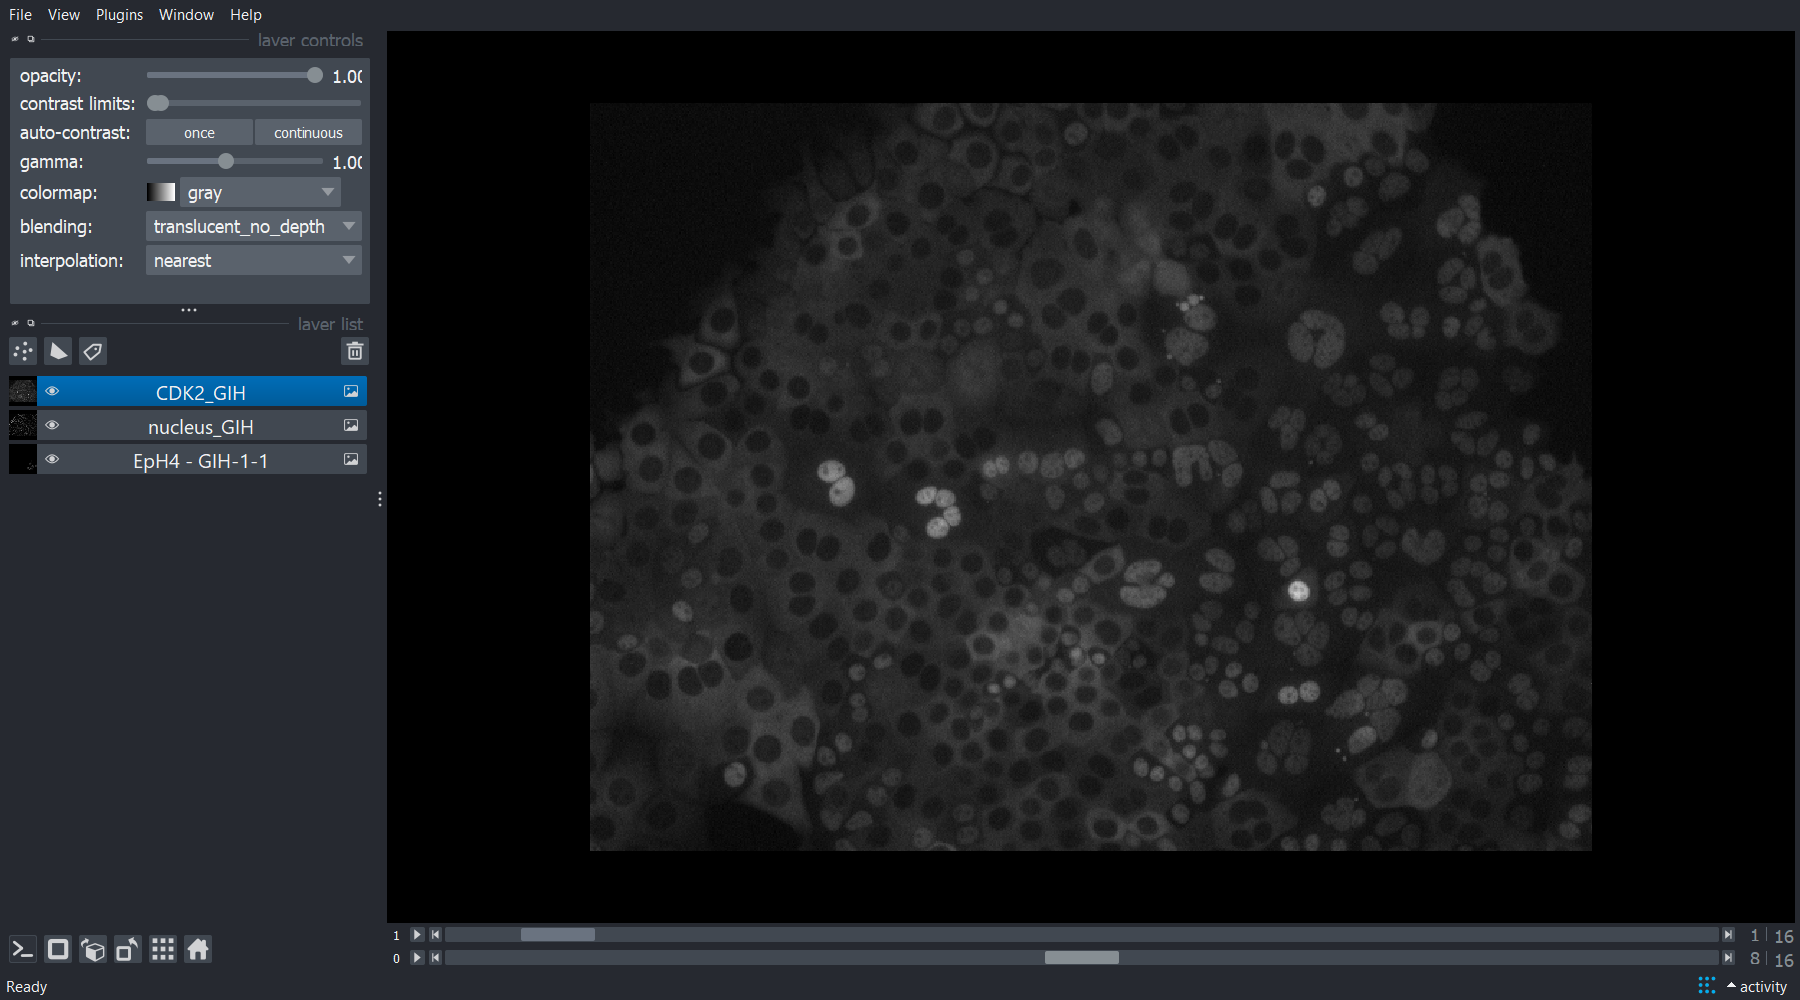

In [39]:
dataset_path = Path('EpH4_CDKs_GIH_ContacInh/')

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*EpH4 - GIH*.tif", )), stack=True)
nucleus_GIH = viewer.layers[0].data[:, 3, :, :]# get frame from number 2 to avoid jittering in the first frame
CDK2_GIH = viewer.layers[0].data[:, 2, :, :]# get frame from number 2 to avoid jittering in the first frame
viewer.add_image(nucleus_GIH, visible=True)
viewer.add_image(CDK2_GIH, visible=True)
nbscreenshot(viewer)

In [40]:
file = (glob.glob('EpH4_CDKs_GIH_ContacInh/*EpH4*.tif'))
tiff_files = 'EpH4_CDKs_GIH_ContacInh\\EpH4 - Contat-1-1.tif'
filename = tiff_files.split('\\')[1]

condition = re.findall('.* - (.*)-.*-.*-.tif', filename)
condition 
#  technical_replicate = re.findall('.* .*-.*-(.*)-.*-.*.Bmp', filename)[0]

[]

In [41]:

# CELLPOSE DID NOT WORK FOR THESE CELLS 

# '''The code for retrieving file information about conditions and replicates was based on #https://github.com/guiwitz/neubias_academy_biapy/blob/master/16-Experiment_analysis.ipynb
# #BSD 3-Clause License Copyright (c) 2021, University of Bern, Mathematical Institute and Microscopy Imaging Center, Guillaume Witz'''

# from skimage import morphology, io, measure
# import pyclesperanto_prototype as cle
# import glob
# import re
# import pandas as pd
# import numpy as np
# import cellpose.models as models
# from natsort import natsorted

# tiff_files = glob.glob('EpH4_CDKs_GIH_ContacInh/*EpH4*.tif')
# tiff_files = natsorted(tiff_files)
# # Load the cellpose model and adjust cellpose parameters (i.e channels = [0, 0], flow_threshold = 1.0, diameter = 20.0)
# model = models.Cellpose(gpu=True, model_type='nuclei')  # if no GPU, set gpu=False
# channels = [0, 0]  # Processing single channel greyscale images for cellpose
# flow_threshold = 0.7
# diameter = 15
# # Parameters to measure with properties
# properties = ['label', 'mean_intensity']  
# # List to contain the dataframes with the results
# results_eroded = []  
# results_ring = []
# eroded_all= []
# ring_all = []
# # Set disk size and radius sizes for label erosion and dilation 
# sigma = 1
# disk_1 = morphology.disk(1.0)
# radius_cyto = 3
# radius_dilated_nucleus = 1

# # For loop for running nuclear segmentation, generation of eroded and ring labels and quantification
# for img in range(len(tiff_files)):
#     print("Processing image:", img)
#     image = imread(tiff_files[img])
#     nucleus = image[:, :, 3]
#     probe = image[:, :, 2]
#     gaussian = filters.gaussian(nucleus, sigma=sigma, preserve_range=True)
    
#     label_image, flows, styles, diams = model.eval(gaussian, flow_threshold=flow_threshold, diameter=diameter, channels=channels)
   
#     #generate pseudo cytoplasm label
#     cyto_label = cle.dilate_labels(label_image, radius=radius_cyto)
#     #generate dilated nucleus label
#     dilated_nucleus = cle.dilate_labels(label_image, radius=radius_dilated_nucleus)
#     #shrink (erode) the nuclear label
#     eroded = morphology.erosion(label_image, disk_1)
#     #generate ring label
#     ring = cyto_label - dilated_nucleus
#     #convert labels from float to int so it can be measured with skimage.measure.regionprops_table
#     ring = np.array(ring).astype(int)
#     eroded = np.array(eroded).astype(int) 
     
#     #perform measurements
#     data_eroded = measure.regionprops_table(eroded, intensity_image=probe, properties=properties)
#     data_ring = measure.regionprops_table(ring, intensity_image=probe, properties=properties)
#     #convert skimage.measure.regionprops_table output (a dictionary) into pandas DataFrame
#     df_results_eroded = pd.DataFrame(data_eroded)
#     df_results_ring = pd.DataFrame(data_ring)

# #     '''we need to get the ids of each image. Get this info from the file names.
# #     Get the replicate (rep1, rep2, etc)  and get conditions (control or treated, for example)'''
#     df_results_eroded['filename'] = tiff_files[img].split('\\')[1]
#     df_results_eroded['condition'] = re.findall('.* - (.*)-.*-.*.tif', tiff_files[img].split('\\')[1])[0]
# # # #     technical_replicate = re.findall('.* .*-.*-(.*)-.*-.*.Bmp', filename)[0]

# #     
    
# #     df_results_eroded['technical_replicate'] = technical_replicate
# #     append dataframes into a single one
#     results_eroded.append(df_results_eroded)
#     results_ring.append(df_results_ring)
#     eroded_all.append(eroded)
#     ring_all.append(ring)

# #data wrangling to cancatanate dataframes
# df_results_eroded = pd.concat([df.reset_index(drop=True) for df in results_eroded], ignore_index=True)
# df_results_ring = pd.concat([df.reset_index(drop=True) for df in results_ring], ignore_index=True)

# # Calculate the ratio directly on the DataFrame
# df_results_eroded['CDK2_activity'] = df_results_ring['mean_intensity'] / df_results_eroded['mean_intensity']

### Steps - segment nucleus, get bbox, crop images, resize, quantify fluorescence, do QC with total intensity for cells 

In [3]:



'''The code for retrieving file information about conditions and replicates was based on #https://github.com/guiwitz/neubias_academy_biapy/blob/master/16-Experiment_analysis.ipynb
#BSD 3-Clause License Copyright (c) 2021, University of Bern, Mathematical Institute and Microscopy Imaging Center, Guillaume Witz'''

from skimage import morphology, io, measure
import pyclesperanto_prototype as cle
import glob
import re
import pandas as pd
import numpy as np
import cellpose.models as models
from natsort import natsorted

tiff_files = glob.glob('EpH4_CDKs_GIH_ContacInh/*EpH4*.tif')
tiff_files = natsorted(tiff_files)
# Load stardist model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Parameters to measure with properties
properties = ['label', 'mean_intensity']  
# List to contain the dataframes with the results
results_eroded = []  
results_ring = []
eroded_all= []
ring_all = []
# Set disk size and radius sizes for label erosion and dilation 
sigma = 1
disk_1 = morphology.disk(1.0)
radius_cyto = 2
radius_dilated_nucleus = 1

# For loop for running nuclear segmentation, generation of eroded and ring labels and quantification
for img in range(len(tiff_files)):
    print("Processing image:", img)
    image = imread(tiff_files[img])
    nucleus = image[:, :, 3]
    probe = image[:, :, 2]
    gaussian = filters.gaussian(nucleus, sigma=sigma, preserve_range=True)
    
    label_image, _ = model.predict_instances(normalize(gaussian))
   
    #generate pseudo cytoplasm label
    cyto_label = cle.dilate_labels(label_image, radius=radius_cyto)
    #generate dilated nucleus label
    dilated_nucleus = cle.dilate_labels(label_image, radius=radius_dilated_nucleus)
    #shrink (erode) the nuclear label
    eroded = morphology.erosion(label_image, disk_1)
    #generate ring label
    ring = cyto_label - dilated_nucleus
    #convert labels from float to int so it can be measured with skimage.measure.regionprops_table
    ring = np.array(ring).astype(int)
    eroded = np.array(eroded).astype(int) 
     
    #perform measurements
    data_eroded = measure.regionprops_table(eroded, intensity_image=probe, properties=properties)
    data_ring = measure.regionprops_table(ring, intensity_image=probe, properties=properties)
    #convert skimage.measure.regionprops_table output (a dictionary) into pandas DataFrame
    df_results_eroded = pd.DataFrame(data_eroded)
    df_results_ring = pd.DataFrame(data_ring)

#     '''we need to get the ids of each image. Get this info from the file names.
#     Get the replicate (rep1, rep2, etc)  and get conditions (control or treated, for example)'''
    df_results_eroded['filename'] = tiff_files[img].split('\\')[1]
    df_results_eroded['condition'] = re.findall('.* - (.*)-.*-.*.tif', tiff_files[img].split('\\')[1])[0]
# # #     technical_replicate = re.findall('.* .*-.*-(.*)-.*-.*.Bmp', filename)[0]

#     
    
#     df_results_eroded['technical_replicate'] = technical_replicate
#     append dataframes into a single one
    results_eroded.append(df_results_eroded)
    results_ring.append(df_results_ring)
    eroded_all.append(eroded)
    ring_all.append(ring)

#data wrangling to cancatanate dataframes
df_results_eroded = pd.concat([df.reset_index(drop=True) for df in results_eroded], ignore_index=True)
df_results_ring = pd.concat([df.reset_index(drop=True) for df in results_ring], ignore_index=True)

# Calculate the ratio directly on the DataFrame
df_results_eroded['CDK2_activity'] = df_results_ring['mean_intensity'] / df_results_eroded['mean_intensity']

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Processing image: 0
Processing image: 1
Processing image: 2
Processing image: 3
Processing image: 4
Processing image: 5
Processing image: 6
Processing image: 7
Processing image: 8
Processing image: 9
Processing image: 10
Processing image: 11
Processing image: 12
Processing image: 13
Processing image: 14
Processing image: 15
Processing image: 16
Processing image: 17
Processing image: 18
Processing image: 19
Processing image: 20
Processing image: 21
Processing image: 22


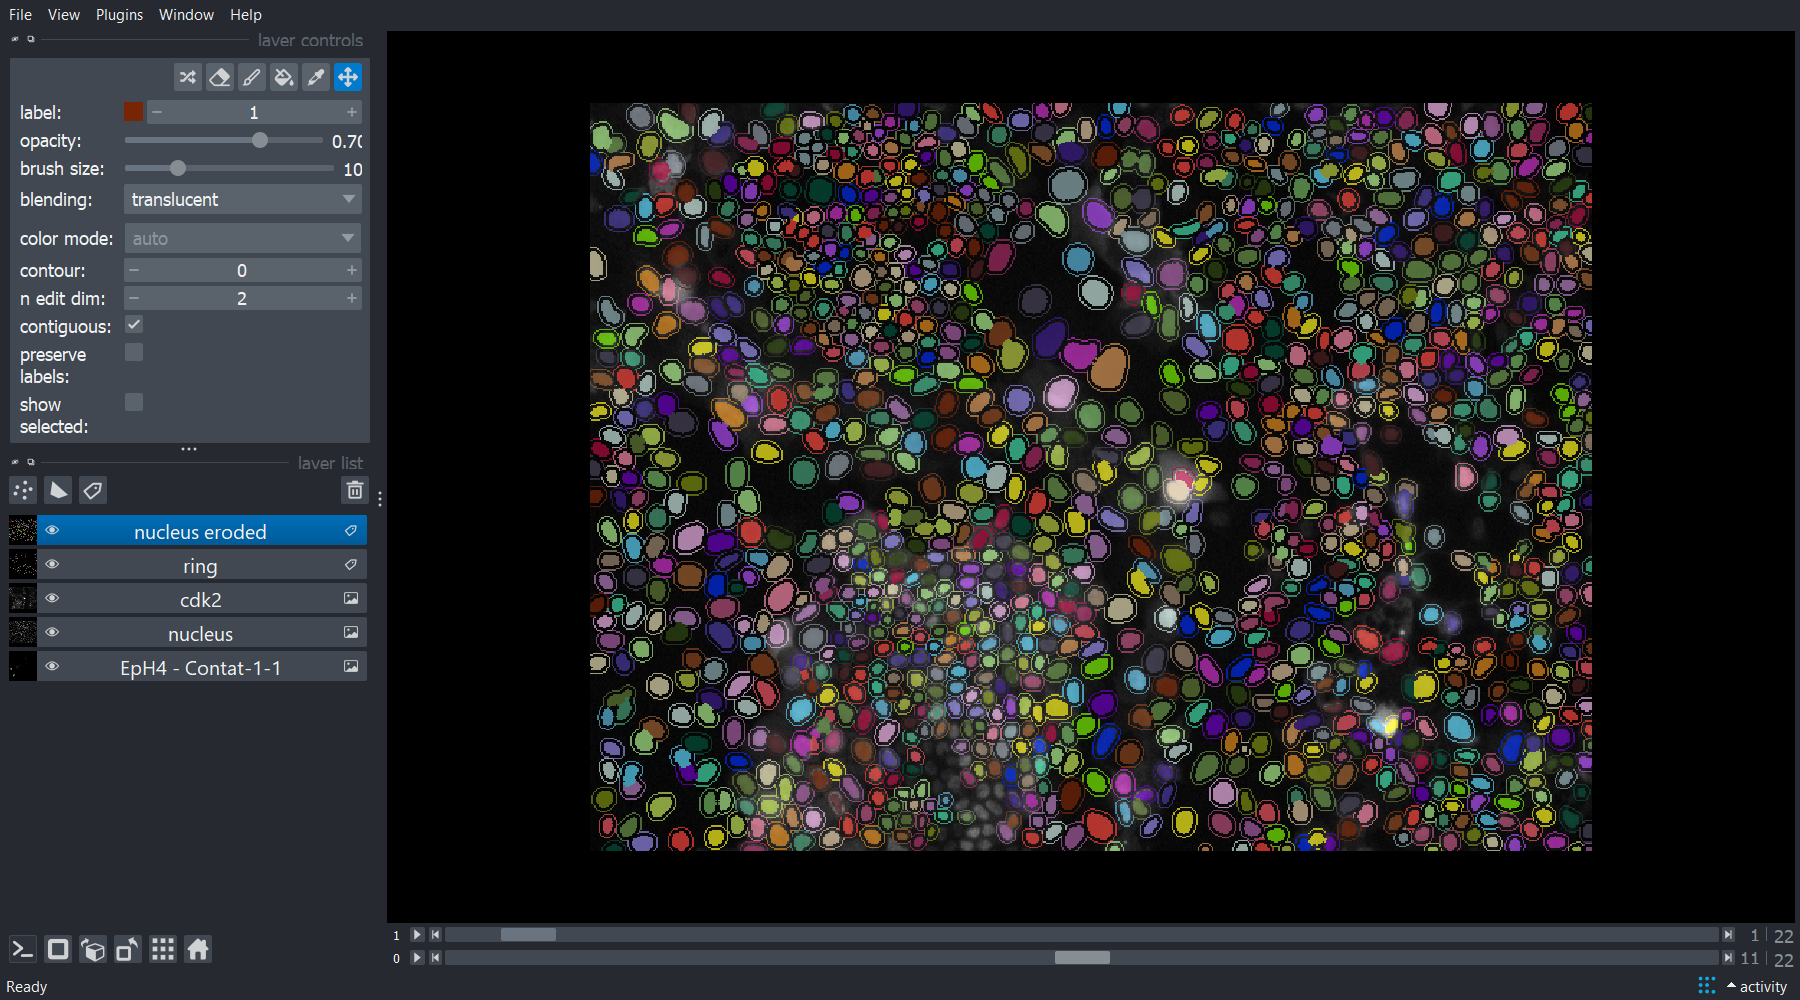

In [4]:
dataset_path = Path('EpH4_CDKs_GIH_ContacInh/')
eroded_all = np.array(eroded_all)
ring_all = np.array(ring_all)
viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*EpH4*.tif", )), stack=True)
nucleus = viewer.layers[0].data[:, 3, :, :]
cdk2 = viewer.layers[0].data[:, 2, :, :]

viewer.add_image(nucleus, visible=True)
viewer.add_image(cdk2, visible=True)
viewer.add_labels(ring_all, name="ring")
viewer.add_labels(eroded_all, name="nucleus eroded")
nbscreenshot(viewer)

In [5]:
df_results_eroded

,label,mean_intensity,filename,condition,CDK2_activity
0,1,693.770270,EpH4 - Contat-1-1.tif,Contat,0.699230
1,2,562.056338,EpH4 - Contat-1-1.tif,Contat,0.682828
2,3,263.942149,EpH4 - Contat-1-1.tif,Contat,0.995688
3,4,273.642336,EpH4 - Contat-1-1.tif,Contat,0.980361
4,5,454.441176,EpH4 - Contat-1-1.tif,Contat,1.007790
...,...,...,...,...,...
14785,448,300.528302,EpH4 - GIH-6-3.tif,GIH,0.924562
14786,449,346.217391,EpH4 - GIH-6-3.tif,GIH,0.882765
14787,450,409.992537,EpH4 - GIH-6-3.tif,GIH,0.909686
14788,451,426.920000,EpH4 - GIH-6-3.tif,GIH,1.194798


In [45]:
df_results_eroded['CDK2_activity'].describe()


count    14789.000000
mean         1.048237
std          0.754436
min          0.032610
25%          0.636235
50%          0.948540
75%          1.225082
max         17.650789
Name: CDK2_activity, dtype: float64

In [6]:
df_results_eroded['total_intensity_mean'] = df_results_eroded['mean_intensity'] + df_results_ring['mean_intensity']
#get only the top 25% (quantile 0.75)


# # Calculate the 75th percentile of the average int_mean values
percentile_50 = df_results_eroded['total_intensity_mean'].quantile(0.50)

# # Filter the DataFrame to only include rows where the average int_mean is greater than or equal to the 75th percentile
df_top_50_percent = df_results_eroded[df_results_eroded['total_intensity_mean'] >= percentile_50]

In [47]:
df_top_50_percent.describe()

,label,mean_intensity,CDK2_activity,total_intensity_mean
count,7395.000000,7395.000000,7395.000000,7395.000000
mean,410.422177,580.572473,1.025731,1024.107632
std,343.751408,333.310425,0.980775,348.579617
min,1.000000,115.218487,0.032610,720.732045
25%,146.000000,404.548276,0.505748,809.731276
50%,310.000000,508.538462,0.770170,919.111857
75%,575.000000,653.055921,1.176521,1110.245825
max,1419.000000,4073.483333,17.650789,4467.566667


554061927.py (2): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='condition', ylabel='CDK2_activity'>

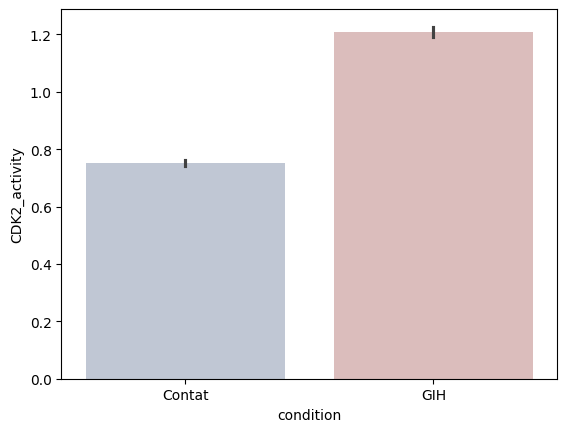

In [7]:
import seaborn as sns
sns.barplot(x="condition", y="CDK2_activity", data=df_top_50_percent, palette = "vlag", errorbar="se")

387393551.py (7): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

387393551.py (8): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



(0.0, 4.0)

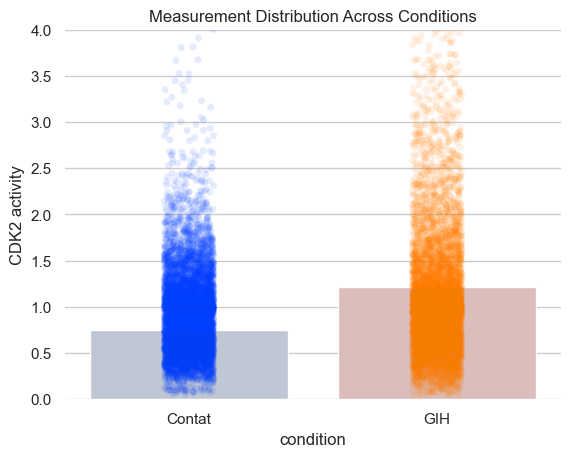

In [8]:
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Create the violin plot
# sns.violinplot(x="condition", y="CDK2_activity", data=df_results_eroded, inner=None, scale="width", cut=0, palette = "vlag")

# Overlay a swarm plot on top of the violin plot
sns.stripplot(x="condition", y= "CDK2_activity", data=df_results_eroded, size=5, palette='bright', alpha=0.1)
sns.barplot(x="condition", y="CDK2_activity", data=df_top_50_percent, palette = "vlag", errorbar="se")
plt.title("Measurement Distribution Across Conditions")
plt.xlabel("condition")
plt.ylabel("CDK2 activity")
sns.despine(left=True, bottom=True)
plt.ylim(0,4)


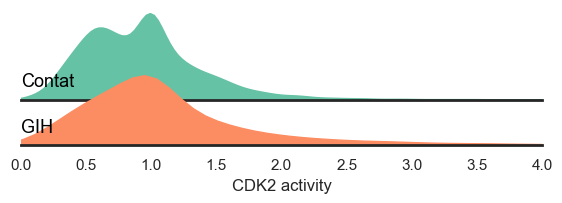

In [15]:
#used this tutorial to make the plothttps://plainenglish.io/blog/ridge-plots-with-pythons-seaborn-4de5725881af

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_results_eroded, palette=palette, row="condition", hue="condition", aspect=5, height=1.2)
g.map_dataframe(sns.kdeplot, x="CDK2_activity", fill=True, alpha=1)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "condition")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="CDK2 activity", ylabel ='')
plt.xlim(0,4)
g.despine( left=True)

In [17]:
# https://python-graph-gallery.com/raincloud-plot-with-matplotlib-and-ptitprince/  
# A rainplot is a visualization that combines half-density plots, jittered points, and boxplotsabs
!pip install --upgrade ptitprince seaborn
import ptitprince as pt

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)


ImportError: cannot import name '_CategoricalScatterPlotter' from 'seaborn.categorical' (C:\Users\bruni\miniconda3\envs\napari-env\lib\site-packages\seaborn\categorical.py)